In [115]:
!pip install gstools

In [116]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

In [117]:
m = 100
n = 110

In [118]:
x = np.linspace(0,1,m)

In [119]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [120]:
seed = MasterRNG(45)
def one_function(x):
  model = Gaussian(dim=1, var=3, len_scale=0.3)
  srf = SRF(model, seed=seed())
  f = srf.structured([x])
  return f

In [121]:
U = np.zeros((m,n)) # m is the number of points in the curve (100) in the x direction. and n is the number of data points that we have
for i in range(m):
  U[:,i] = one_function(x)

In [122]:
print(U.shape)

(100, 110)


In [123]:
print(U)

[[ 0.09697055  0.18203776  0.62625848 ...  0.          0.
   0.        ]
 [ 0.26906781  0.04565353  0.63722051 ...  0.          0.
   0.        ]
 [ 0.44763625 -0.09240118  0.64723774 ...  0.          0.
   0.        ]
 ...
 [-0.51559073 -1.04475022 -1.41395892 ...  0.          0.
   0.        ]
 [-0.3328682  -0.91703105 -1.41624014 ...  0.          0.
   0.        ]
 [-0.15220292 -0.78962905 -1.41045278 ...  0.          0.
   0.        ]]


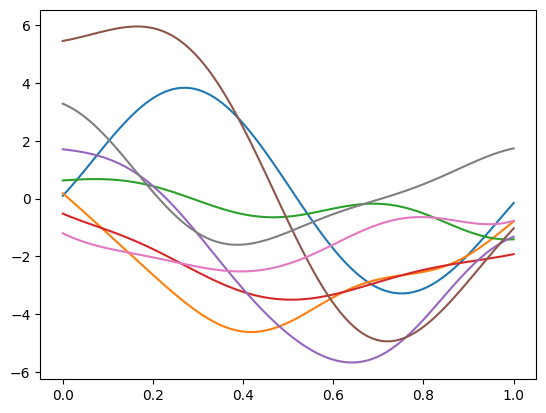

In [124]:
plt.plot(x, U[:, :8])

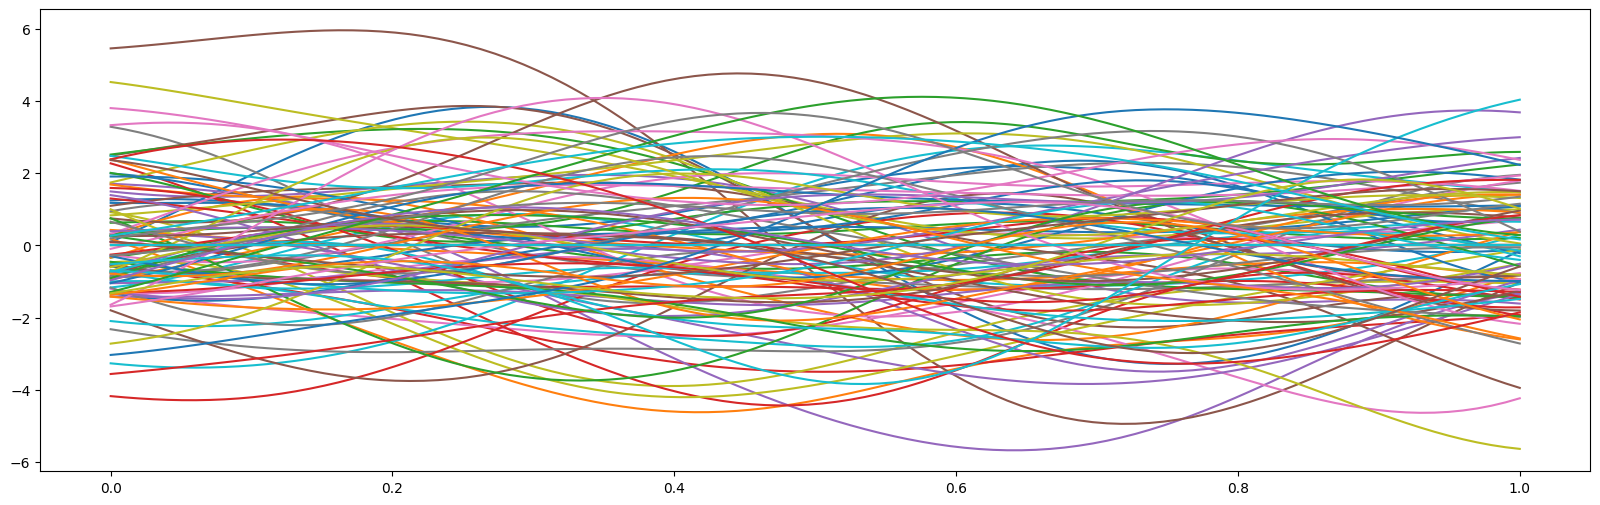

In [125]:
plt.figure(figsize=(20,6))
plt.plot(x, U[:, :])

# **Understanding the Integration**

*   The Goal: The function integrate_one_function(f) is designed to numerically integrate the given function f. Integration, in this context, can be thought of as calculating the area under the curve of f over a specific interval. For example, if f represents a velocity curve over time, the integration would give you the displacement.
*   integrate.simps: This method uses Simpson's rule, a numerical technique, to approximate the integral of the function. Simpson's rule divides the function into segments and fits a quadratic polynomial to approximate the area under the curve.


#**Looping through the data:**


*   result = np.zeros_like(f) initializes an array to store the integrated values of the function.
*   result[i] = integrate.simps(f[:i+1], x[:i+1]) calculates the integral of the function f up to the current index i. This accumulates the area under the curve, step by step.


In [126]:
def integrate_one_function(f):
  result = np.zeros_like(f)
  result[0] = 0
  for i in range(1, len(f)):
    result[i] = integrate.simps(f[:i+1], x[:i+1])
  return result

<ipython-input-126-37183ce0a292>:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  result[i] = integrate.simps(f[:i+1], x[:i+1])


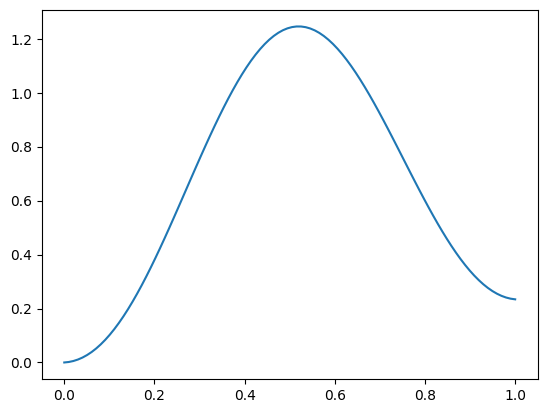

In [127]:
f = U[:,0]
f_int = integrate_one_function(f)
plt.plot(x,f_int)

This plot shows the original curve, which you are trying to approximate.

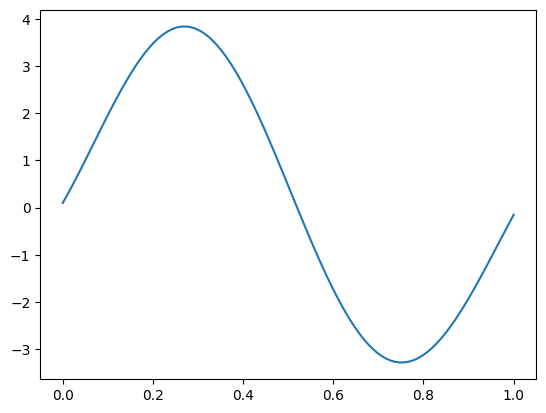

In [128]:
plt.plot(x,f)

This is the integrated curve, which represents the cumulative sum (or area under the curve) of the original function. As you integrate the function, you are effectively "summing up" the values over the interval, which changes the shape of the plot.

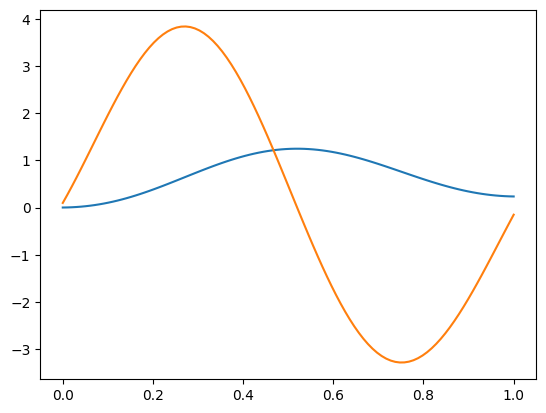

In [129]:
plt.plot(x,f_int)
plt.plot(x,f)

# **How This Fits Together**

*   Integration (f_int): By integrating the function f, you are building a cumulative representation of the curve, which can help in training models like neural networks to approximate or learn this behavior.
*   Training Random Curves: The set of random curves is likely an initial guess for the model you are training. By comparing these curves with your integrated result (f_int), you can adjust their parameters to make them approximate the desired curve.

# **The S Matrix**

*   Integration for Each Column: S[:,i] = integrate_one_function(U[:,i]) means that for each column in U, you apply the same integration process. U could be a matrix of functions or potential solutions, and S will store their cumulative (integrated) results.
*   Training Neural Networks: This cumulative integration can provide valuable information for neural networks by transforming the data into a different space that might be easier to learn or approximate.

In [130]:
S = np.zeros((m,n)) # this would be the integration
for i in range(n):
  S[:,i] = integrate_one_function(U[:,i])

<ipython-input-126-37183ce0a292>:5: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  result[i] = integrate.simps(f[:i+1], x[:i+1])


In [131]:
print(S[:,0])

[0.         0.00184868 0.0054575  0.01090379 0.01823242 0.02747983
 0.0386747  0.05183022 0.0669516  0.08402821 0.10304143 0.12395689
 0.14673245 0.17131069 0.19762686 0.22560183 0.25514971 0.28617148
 0.31856215 0.35220514 0.38697879 0.42275169 0.45938836 0.49674556
 0.5346771  0.5730312  0.61165426 0.65038933 0.68907879 0.72756401
 0.76568679 0.80329016 0.84021876 0.87632059 0.9114463  0.94545202
 0.97819747 1.00954974 1.03938038 1.06757006 1.09400464 1.11858058
 1.1412002  1.16177764 1.18023342 1.19650087 1.21052007 1.22224461
 1.23163509 1.23866608 1.24331923 1.24559033 1.24548225 1.24301189
 1.23820302 1.23109314 1.22172632 1.21015971 1.19645666 1.18069275
 1.16294923 1.14331852 1.12189808 1.09879529 1.07412188 1.04799804
 1.02054753 0.991901   0.96219181 0.9315585  0.90014146 0.86808447
 0.83553219 0.80263087 0.76952671 0.7363656  0.70329249 0.67045015
 0.6379795  0.60601751 0.57469842 0.54415084 0.51449981 0.48586316
 0.45835449 0.4320787  0.40713582 0.38361602 0.36160402 0.3411

we need this data in a shape that we can use to train our deeponet
https://arxiv.org/pdf/1910.03193

Lu Lu has some good documentation for pinns

* Using Your Curve Data (Branch Net): Your collected curve values (S[:, 0]) are fed into the branch net. This network encodes the entire curve into a set of learnable parameters that capture the essential features of your input curve.

* Using Evaluation Points (Trunk Net): The trunk net receives the specific points (y) where you want to evaluate the output of the function. For example, these points could be the locations along a spatial dimension where you want to predict some property like wind speed.

* Producing the Output: The combination of the branch net's output (representing your curve) and the trunk net's evaluation at specific points allows the DeepONet to predict the values of a new function or field. This setup enables the network to learn a mapping from input curves to their respective outputs at various coordinates.

In simpler terms, the branch net processes your input curve into a compressed format, while the trunk net focuses on the evaluation points. Together, they allow you to model the relationship between input functions (your curve data) and outputs (the predictions you want to make).

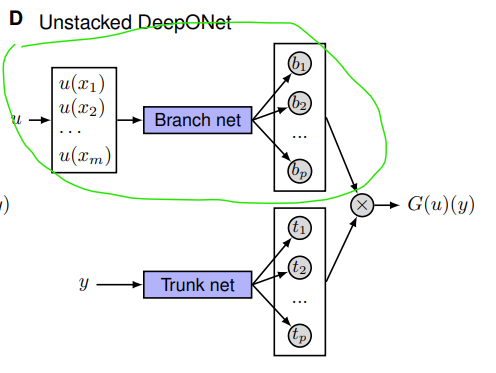

In [132]:
# U solver needs to be in the shape of m * n = 11000 data points (11000, 100) we are basically doing closest point from GH...
# us -> m*n = 11000 ==> us (11000, 100)
# xs -> (11000, 1)
# ss -> (11000, 1)

* m: Number of rows (in this context, 100 as seen in the comment).
* n: Number of columns.
* x: An array of values.
* U: Matrix or data of shape (m, n) from which data will be extracted.
* S: Another matrix, likely containing values for integration or simulation.

Recap: DeepONet Structure

* Branch Net: Takes the input curve data (us in this case).
* Trunk Net: Takes the coordinates or evaluation points (xs).
* The model then combines both to learn the mapping from input functions (curves) to the output function (ss).

Breakdown of us, xs, and ss
* us (Branch Input, the Selected Curve Data):

  * Represents the input functions for the DeepONet's Branch Net.
  * In this code, us is constructed by taking columns from the matrix U. Each column in U can be seen as a function or curve. By storing these columns into us, you are essentially feeding the model with the various input curves.
  * us has the shape (11000, 100) where each row corresponds to a different "sampled" input curve and the 100 columns represent the data points (features) of each curve.
  * Key Point: us is collecting all possible input curves from the matrix U.
* xs (Trunk Input, Evaluation Points):

  * Represents the locations or the input points where the network will evaluate the output.
  * This corresponds to the "evaluation coordinates" you are using to probe the output of the network in the DeepONet's Trunk Net.
  * In the function, xs takes values directly from the array x, which appears to be a grid or a set of evaluation points. This setup helps the model understand the spatial or sequential dependency of the data.
  * Key Point: xs serves as the coordinates or input points for evaluating the curves.
* ss (Output Data, Target Values or Output Curves):
  * Represents the target data or the output function values that you want the model to approximate.
  * It collects values from the matrix S. In this context, S could contain the results of some transformations or evaluations of the input functions (U). Essentially, it stores the expected outputs for each input curve and coordinate pair.
  * Key Point: ss contains the output values that the network will be trained to approximate, given the inputs from us and xs.
Connecting us, xs, and ss to the Earlier DeepONet Diagram
* Branch Net (us): The input functions or curves are passed into the Branch Net. Each row in us corresponds to one such input curve, which the network will use to learn a mapping.
* Trunk Net (xs): This represents the coordinates or points at which you want to evaluate the output curve.
* Output (ss): These are the target values that the network aims to predict at each evaluation point (from xs) for each input curve (from us).
How They Work Together
* Curves in us: This set contains all the input curves that the DeepONet will use in the learning process. For each curve, the network learns how to map its features through the Branch Net.
* Evaluation Points in xs: For each curve, the network evaluates it at various points using the Trunk Net.
* Target Values in ss: The network compares its output to these values during training to minimize the error and learn an accurate mapping between input curves and their corresponding outputs.

In [133]:
# m = 100
# n = 110

def interate_data(m=m, n=n, x=x, U=U, S=S):
  us = np.zeros((m*n, m))
  xs = np.zeros((m*n, 1))
  ss = np.zeros((m*n, 1))
  for i in range(n):
    for j in range(m):
      us[i*m+j, :] = U[:,i]
      xs[i*m+j, :] = x[j]
      ss[i*m+j, :] = S[j, i]
    return us, xs, ss

In [134]:
us, xs, ss = interate_data()
print("us.shape: ", us.shape)
print("xs.shape: ", xs.shape)
print("ss.shape", ss.shape)

us.shape:  (11000, 100)
xs.shape:  (11000, 1)
ss.shape (11000, 1)


In [135]:
us #all the curves in rows

array([[ 0.09697055,  0.26906781,  0.44763625, ..., -0.51559073,
        -0.3328682 , -0.15220292],
       [ 0.09697055,  0.26906781,  0.44763625, ..., -0.51559073,
        -0.3328682 , -0.15220292],
       [ 0.09697055,  0.26906781,  0.44763625, ..., -0.51559073,
        -0.3328682 , -0.15220292],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [136]:
xs # just the location off the points

array([[0.        ],
       [0.01010101],
       [0.02020202],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [137]:
# turn the data innto tensors

def batch_data(batch_size, m=m, n=n, U=U, S=S, ratio=0.9):
  us, xs, ss = interate_data(m, n, x, U, S)

  train_size = int(len(us) * ratio)

  us_train = us[:train_size]
  xs_train = xs[:train_size]
  ss_train = ss[:train_size]

  us_test = us[train_size:]
  xs_test = xs[train_size:]
  ss_test = ss[train_size:]

  # train
  us_train = torch.tensor(us_train, dtype=torch.float32)
  xs_train = torch.tensor(xs_train, dtype=torch.float32)
  ss_train = torch.tensor(ss_train, dtype=torch.float32)
  train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  # test
  us_test = torch.tensor(us_test, dtype=torch.float32)
  xs_test = torch.tensor(xs_test, dtype=torch.float32)
  ss_test = torch.tensor(ss_test, dtype=torch.float32)
  test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  return train_dataloader, test_dataloader

In [138]:
train_data, test_data = batch_data(batch_size=32, ratio=0.9)

In [139]:
for u_batch, x_batch, s_batch in train_data:
  print(u_batch.shape, x_batch.shape, s_batch.shape)
  break # brak just to do it one time

torch.Size([32, 100]) torch.Size([32, 1]) torch.Size([32, 1])


In [140]:
u_batch

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [141]:
x_batch

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.3737],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]])

# Building the Model

In [149]:
class DeepONet(nn.Module):
  def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
    super(DeepONet, self).__init__()

    # these are the values we need to initialize
    self.in1 = in1
    self.in2 = in2
    self.neurons = neurons
    self.output_neurons = output_neurons

    # The slip data goes into two different nns
    self.branch = self.branch_network()
    self.trunk = self.trunk_network()

  # this nn takes the majority of the data based on the ratio 800 rows or curves or functions
  def branch_network(self):
    branch = nn.Sequential(
        nn.Linear(self.in1, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.output_neurons),
    )
    return branch
  # this trunk nn takes the rest of the data which is 200
  def trunk_network(self):
    trunk = nn.Sequential(
        nn.Linear(self.in2, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.neurons),
        nn.ReLU(),
        nn.Linear(self.neurons, self.output_neurons),
    )
    return trunk

  def forward(self, x1, x2):
    x1 = self.branch(x1)
    x2 = self.trunk(x2)
    x = torch.einsum("bi, bi->b", x1, x2) # this is a multiplication between x1 and x2
    x = torch.unsqueeze(x,1)
    return x

In [150]:
'''
# this shape is a 3 by 2 matrix.. 3 rows and 2 columns
x1 = torch.tensor([[1,2],
                   [3,4],
                   [5,6]])
print(x1.shape)

x2 = torch.tensor([[2,3],
                   [4,5],
                   [6,7]])
print(x2.shape)
'''

'\n# this shape is a 3 by 2 matrix.. 3 rows and 2 columns\nx1 = torch.tensor([[1,2],\n                   [3,4],\n                   [5,6]])\nprint(x1.shape)\n\nx2 = torch.tensor([[2,3],\n                   [4,5],\n                   [6,7]])\nprint(x2.shape)\n'

* torch.einsum("bi, bi->b", x1, x2) performs an element-wise multiplication between x1 and x2 for each row, and then sums the products across the columns.
* The "bi, bi->b" notation tells einsum to multiply corresponding elements in the same row (for each column) and sum the result for each row.
* The final output is a 1D tensor where each element is the result of the summation for the respective row in the input tensors.

In [151]:
'''
The expression "bi, bi->b" essentially multiplies
the corresponding elements of x1 and x2 across
the second dimension (columns) and sums
them for each row.

Let's calculate this manually:

First row: Multiply (1 * 2) + (2 * 3) =
Second row: Multiply (3 * 4) + (4 * 5) = 32
Third row: Multiply (5 * 6) + (6 * 7) = 72

The final result tensor would be: [8, 32, 72].

'''
result = torch.einsum("bi, bi->b", x1, x2)
print(result)

tensor([ 8, 32, 72])


In [152]:
'''
# what if we if this
x1 = torch.tensor([[1,2],
                   [3,4],
                   [5,6]])
print(x1.shape)

x2 = torch.tensor([[2,3],
                   [4,5],
                   [6,7]])
print(x2.shape)
'''

'\n# what if we if this \nx1 = torch.tensor([[1,2],\n                   [3,4],\n                   [5,6]])\nprint(x1.shape)\n\nx2 = torch.tensor([[2,3],\n                   [4,5],\n                   [6,7]])\nprint(x2.shape)\n'

In [153]:
'''
result = torch.einsum("bi, bi->i", x1, x2)
print(result)
'''

'\nresult = torch.einsum("bi, bi->i", x1, x2)\nprint(result)\n'

In [154]:
'''
print("first ele", 1*2 + 3*4 + 5*6)
print("second ele", 2*3 + 4*5 + 6*7)
'''

'\nprint("first ele", 1*2 + 3*4 + 5*6)\nprint("second ele", 2*3 + 4*5 + 6*7)\n'

#now we need to define the model

In [155]:
model = DeepONet(neurons=40, in1=m, in2=1)
model

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

# Define the loss function

In [156]:
def loss(y_pred, y):
  return torch.mean((y_pred - y)**2)

#Define the optimizer

In [157]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Now we start the training process

In [160]:
train_losses = []
epochs = 200 # 500 and up should be better result of a decreasing top to bottom left to right
for i in range(epochs):
  l_total = 0
  for u_batch, x_batch, s_batch in train_data:
    model.train()
    optimizer.zero_grad() # this is before the traiing process to initiate back propagation
    y_pred = model(u_batch, x_batch)

    l = loss(y_pred, s_batch)
    l_total += l.item()
    l.backward() # this is the process in which we are actualy training the network in backpropagation. based on the loss of line 10
    optimizer.step()

  l_total = l_total/len(train_data)
  train_losses.append(l_total)

  if i % 20 == 0:
    print(f"Epoch: {i} / {epochs}, loss: {l_total}") # we will keep printing every 20 epochs

Epoch: 0 / 200, loss: 9.533276818554019e-07
Epoch: 20 / 200, loss: 1.9296072196436618e-06
Epoch: 40 / 200, loss: 2.593245885146131e-06
Epoch: 60 / 200, loss: 6.892067302540987e-07
Epoch: 80 / 200, loss: 3.47497332761765e-06
Epoch: 100 / 200, loss: 5.081872837726069e-06
Epoch: 120 / 200, loss: 3.6517562484238646e-06
Epoch: 140 / 200, loss: 5.2275018982415935e-06
Epoch: 160 / 200, loss: 1.1574276675635276e-06
Epoch: 180 / 200, loss: 2.202557355663662e-06


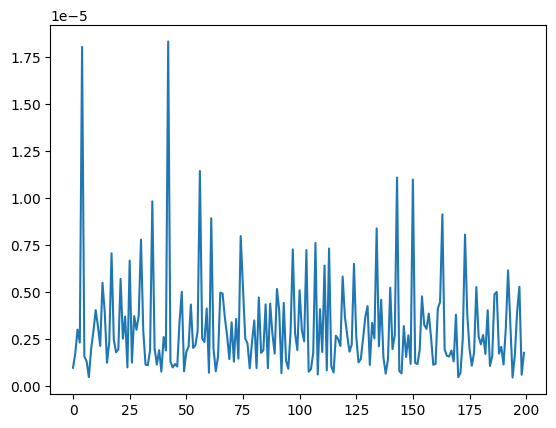

In [161]:
plt.plot(train_losses)

In [164]:
my_func = lambda x: np.cos(5*x)
inter = lambda x: 1/5 * np.sin(5*x)
u_t = my_func(x)
s_t = inter(x)

In [165]:
u_t.shape, s_t.shape

((100,), (100,))

In [166]:
model.eval()

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [169]:
u_t_tensor = torch.tensor(u_t, dtype=torch.float32)
print(u_t_tensor.shape)
print(u_t_tensor)
u_t_tensor = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0)
print(u_t_tensor.shape)
print(u_t_tensor)
x_tens = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
print(x_tens.shape)
# print(x_tens)

torch.Size([100])
tensor([ 1.0000,  0.9987,  0.9949,  0.9885,  0.9797,  0.9683,  0.9544,  0.9382,
         0.9195,  0.8985,  0.8752,  0.8496,  0.8219,  0.7921,  0.7603,  0.7265,
         0.6909,  0.6535,  0.6145,  0.5739,  0.5318,  0.4883,  0.4437,  0.3979,
         0.3510,  0.3033,  0.2548,  0.2057,  0.1560,  0.1060,  0.0556,  0.0051,
        -0.0453, -0.0957, -0.1459, -0.1956, -0.2449, -0.2935, -0.3414, -0.3884,
        -0.4344, -0.4793, -0.5230, -0.5654, -0.6063, -0.6457, -0.6834, -0.7194,
        -0.7536, -0.7858, -0.8160, -0.8441, -0.8701, -0.8939, -0.9154, -0.9345,
        -0.9513, -0.9657, -0.9775, -0.9869, -0.9938, -0.9982, -0.9999, -0.9992,
        -0.9959, -0.9900, -0.9817, -0.9708, -0.9575, -0.9417, -0.9235, -0.9029,
        -0.8801, -0.8550, -0.8277, -0.7983, -0.7669, -0.7335, -0.6983, -0.6613,
        -0.6225, -0.5822, -0.5405, -0.4973, -0.4529, -0.4073, -0.3606, -0.3131,
        -0.2647, -0.2157, -0.1662, -0.1162, -0.0659, -0.0154,  0.0351,  0.0855,
         0.1357,  0.18

In [174]:
p = model(u_t_tensor, x_tens)
p = p.detach().numpy()
# print(p)

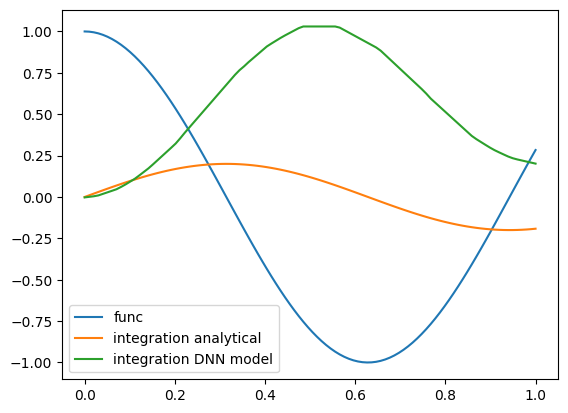

In [178]:
plt.plot(x, u_t, label="func")
plt.plot(x, s_t, label="integration analytical")
plt.plot(x, p, label="integration DNN model")
plt.legend()

In [179]:
my_func = lambda x: np.cos(x) * np.sin(x) # a bit more complex
inter = lambda x: 1/2 * (np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)

In [180]:
model.eval()

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [181]:
u_t_tensor = torch.tensor(u_t, dtype=torch.float32)
print(u_t_tensor.shape)
print(u_t_tensor)
u_t_tensor = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0)
print(u_t_tensor.shape)
print(u_t_tensor)
x_tens = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
print(x_tens.shape)
# print(x_tens)

torch.Size([100])
tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0504, 0.0605, 0.0705, 0.0805,
        0.0904, 0.1003, 0.1102, 0.1200, 0.1298, 0.1395, 0.1492, 0.1588, 0.1684,
        0.1778, 0.1872, 0.1966, 0.2058, 0.2150, 0.2241, 0.2330, 0.2419, 0.2507,
        0.2594, 0.2680, 0.2765, 0.2848, 0.2931, 0.3012, 0.3092, 0.3171, 0.3248,
        0.3324, 0.3399, 0.3472, 0.3544, 0.3615, 0.3684, 0.3751, 0.3817, 0.3882,
        0.3945, 0.4006, 0.4066, 0.4124, 0.4180, 0.4234, 0.4287, 0.4338, 0.4388,
        0.4435, 0.4481, 0.4525, 0.4567, 0.4607, 0.4645, 0.4682, 0.4716, 0.4749,
        0.4780, 0.4808, 0.4835, 0.4860, 0.4882, 0.4903, 0.4922, 0.4939, 0.4954,
        0.4966, 0.4977, 0.4986, 0.4992, 0.4997, 0.4999, 0.5000, 0.4998, 0.4995,
        0.4989, 0.4982, 0.4972, 0.4960, 0.4947, 0.4931, 0.4913, 0.4893, 0.4872,
        0.4848, 0.4822, 0.4794, 0.4765, 0.4733, 0.4700, 0.4664, 0.4627, 0.4588,
        0.4546])
torch.Size([1, 100])
tensor([[0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0504, 0.0605,

In [182]:
p = model(u_t_tensor, x_tens)
p = p.detach().numpy()
# print(p)

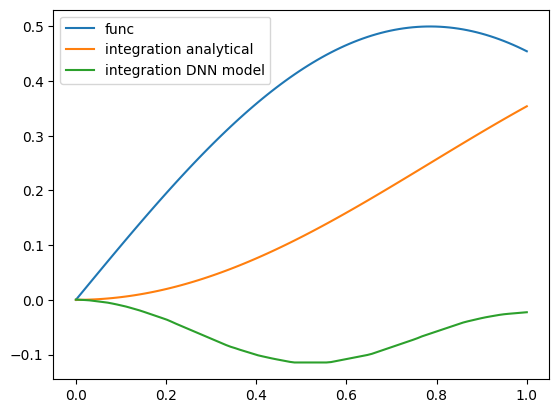

In [183]:
plt.plot(x, u_t, label="func")
plt.plot(x, s_t, label="integration analytical")
plt.plot(x, p, label="integration DNN model")
plt.legend()